In [51]:
# Technical Indicators
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice
from ta.volatility import KeltnerChannel
from ta.momentum import ROCIndicator

# Plotting
import matplotlib.pyplot as plt

# Getting data
import yfinance as yf
import math
import pandas as pd
import numpy as np

In [52]:
stocks = ['META','AMZN', 'AAPL', 'NFLX', 'GOOGL']
weight = 1/len(stocks)

start = '2015-01-01'
end = '2019-12-31'

data = yf.download(stocks, start=start, end=end, progress=False)['Close']
data.index = data.index.date

data

Ticker,AAPL,AMZN,GOOGL,META,NFLX
2015-01-02,27.332500,15.426000,26.477501,78.449997,49.848572
2015-01-05,26.562500,15.109500,25.973000,77.190002,47.311428
2015-01-06,26.565001,14.764500,25.332001,76.150002,46.501431
2015-01-07,26.937500,14.921000,25.257500,76.150002,46.742859
2015-01-08,27.972500,15.023000,25.345501,78.180000,47.779999
...,...,...,...,...,...
2019-12-23,71.000000,89.650002,67.531502,206.179993,333.100006
2019-12-24,71.067497,89.460503,67.221497,205.119995,333.200012
2019-12-26,72.477501,93.438499,68.123497,207.789993,332.630005
2019-12-27,72.449997,93.489998,67.732002,208.100006,329.089996


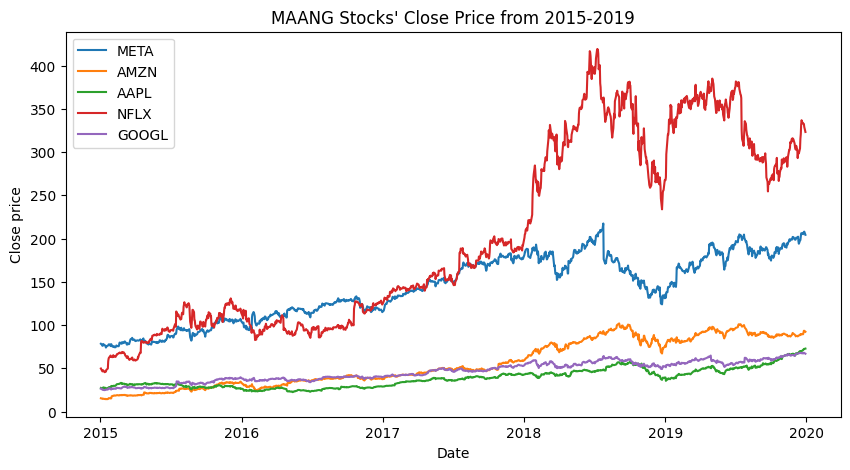

In [53]:
# Plot close price for each stock from 2015-2019

fig = plt.figure(figsize=(10, 5))

for stock in stocks:
    plt.plot(data.index, data[stock], label=stock)

plt.legend()
plt.xlabel('Date')
plt.ylabel('Close price')
plt.title(f'MAANG Stocks\' Close Price from 2015-2019')
plt.show()

**Momentum Strategy: MACD + EMA(200)**

*MACD indicator computation: MACD = EMA(12) - EMA(26) and MACD signal line = EMA(9) of MACD line*

Buy signal:
- MACD crosses above signal line, AND
- Stock price crosses above EMA(200)

Sell signal:
- MACD crosses below signal line, AND
- Stock price crosses below EMA(200)

In [54]:
### Calculate indicators and signal generation

def calculate_indicators(stock, bt_data):
    """Calculate the 200-day EMA and MACD indicators for a given stock."""
    # Calculate EMA 200
    bt_data[f'{stock}_EMA_200'] = bt_data[f'{stock}_Close'].ewm(span=200, adjust=False).mean()

    # Calculate MACD and Signal Line
    exp12 = bt_data[f'{stock}_Close'].ewm(span=12, adjust=False).mean()
    exp26 = bt_data[f'{stock}_Close'].ewm(span=26, adjust=False).mean()
    bt_data[f'{stock}_MACD'] = exp12 - exp26
    bt_data[f'{stock}_Signal_Line'] = bt_data[f'{stock}_MACD'].ewm(span=9, adjust=False).mean()

def generate_signals(stock, bt_data):
    """Generate buy and sell signals for a given stock."""
    bt_data[f'{stock}_Position'] = 0  # 1 for long, -1 for short

    # Generate signals using a loop
    for i in range(1, len(bt_data)):
        T_minus_one = bt_data.index[i - 1]
        T_day = bt_data.index[i]

        # Long signal: Price > EMA 200 AND MACD croses above signal line
        if (bt_data.loc[T_day, f'{stock}_Close'] > bt_data.loc[T_day, f'{stock}_EMA_200']) and \
           (bt_data.loc[T_day, f'{stock}_MACD'] > bt_data.loc[T_day, f'{stock}_Signal_Line']) and \
           (bt_data.loc[T_minus_one, f'{stock}_MACD'] <= bt_data.loc[T_minus_one, f'{stock}_Signal_Line']):
            bt_data.loc[T_day, f'{stock}_Position'] = 1  # Long signal

        # Short signal: Price < EMA 200 AND MACD crosses below signal line
        elif (bt_data.loc[T_day, f'{stock}_Close'] < bt_data.loc[T_day, f'{stock}_EMA_200']) and \
             (bt_data.loc[T_day, f'{stock}_MACD'] < bt_data.loc[T_day, f'{stock}_Signal_Line']) and \
             (bt_data.loc[T_minus_one, f'{stock}_MACD'] >= bt_data.loc[T_minus_one, f'{stock}_Signal_Line']):
            bt_data.loc[T_day, f'{stock}_Position'] = -1  # Short signal

        # Otherwise, previous day's hold position
        else:
            bt_data.loc[T_day, f'{stock}_Position'] = bt_data.loc[T_minus_one, f'{stock}_Position']


In [69]:
# Create a backtest dataframe to store important variables

# Dictionary to hold DataFrame for each stock
stock_tables = {}

for stock in stocks:
    # Create a DataFrame for each stock
    stock_data = pd.DataFrame(index=data.index)
    
    stock_data[f'{stock}_Close'] = data[stock]

    # Calculate indicators for this stock
    calculate_indicators(stock, stock_data)

    # Generate buy and sell signals for this stock
    generate_signals(stock, stock_data)

    # Store the DataFrame in the dictionary
    stock_tables[stock] = stock_data

# Output the head of each stock's DataFrame
for stock, df in stock_tables.items():
    print(f"Head of {stock} DataFrame:")
    display(df.head())  # Display the first few rows of each stock's data



Head of META DataFrame:


,META_Close,META_EMA_200,META_MACD,META_Signal_Line,META_Position
2015-01-02,78.449997,78.449997,0.000000,0.000000,0
2015-01-05,77.190002,78.437460,-0.100512,-0.020102,-1
2015-01-06,76.150002,78.414699,-0.261079,-0.068298,-1
2015-01-07,76.150002,78.392165,-0.383904,-0.131419,-1
2015-01-08,78.180000,78.390054,-0.313822,-0.167900,-1


Head of AMZN DataFrame:


,AMZN_Close,AMZN_EMA_200,AMZN_MACD,AMZN_Signal_Line,AMZN_Position
2015-01-02,15.4260,15.426000,0.000000,0.000000,0
2015-01-05,15.1095,15.422850,-0.025248,-0.005050,-1
2015-01-06,14.7645,15.416300,-0.072263,-0.018492,-1
2015-01-07,14.9210,15.411371,-0.095790,-0.033952,-1
2015-01-08,15.0230,15.407507,-0.104994,-0.048160,-1


Head of AAPL DataFrame:


,AAPL_Close,AAPL_EMA_200,AAPL_MACD,AAPL_Signal_Line,AAPL_Position
2015-01-02,27.332500,27.332500,0.000000,0.000000,0
2015-01-05,26.562500,27.324839,-0.061425,-0.012285,-1
2015-01-06,26.565001,27.317278,-0.108650,-0.031558,-1
2015-01-07,26.937500,27.313499,-0.114696,-0.048186,-1
2015-01-08,27.972500,27.320057,-0.035562,-0.045661,1


Head of NFLX DataFrame:


,NFLX_Close,NFLX_EMA_200,NFLX_MACD,NFLX_Signal_Line,NFLX_Position
2015-01-02,49.848572,49.848572,0.000000,0.000000,0
2015-01-05,47.311428,49.823327,-0.202393,-0.040479,-1
2015-01-06,46.501431,49.790273,-0.423272,-0.117037,-1
2015-01-07,46.742859,49.759950,-0.572243,-0.208078,-1
2015-01-08,47.779999,49.740249,-0.599701,-0.286403,-1


Head of GOOGL DataFrame:


,GOOGL_Close,GOOGL_EMA_200,GOOGL_MACD,GOOGL_Signal_Line,GOOGL_Position
2015-01-02,26.477501,26.477501,0.000000,0.000000,0
2015-01-05,25.973000,26.472481,-0.040245,-0.008049,-1
2015-01-06,25.332001,26.461133,-0.122451,-0.030929,-1
2015-01-07,25.257500,26.449156,-0.191406,-0.063025,-1
2015-01-08,25.345501,26.438175,-0.236228,-0.097665,-1


In [71]:
### Visualise the strategy signals and long/short positions to all 5 individual stocks

def visualize_signals(bt_data, stock):
    """Plot 2 stacked graphs for the provided stock: 
    1. Close price with EMA(200), 
    2. MACD with Signal Line."""
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7), sharex=True, 
                                   gridspec_kw={'height_ratios': [3, 1]})

    # Stock price and EMA(200)
    ax1.set_title(f'{stock} Close Price with 200-day EMA and Buy/Sell Signals')
    ax1.plot(bt_data[f'{stock}_Close'], label=f'{stock} Close Price', color='black', alpha=0.5)
    ax1.plot(bt_data[f'{stock}_EMA_200'], label=f'{stock} 200-day EMA', color='blue')

    # Plot buy and sell signals on price graph
    buy_signals = bt_data[(bt_data[f'{stock}_Position'] == 1) & (bt_data[f'{stock}_Position'].shift(1) != 1)]
    ax1.scatter(buy_signals.index, buy_signals[f'{stock}_Close'], marker='^', color='g', label='Buy Signal', s=100)
    
    sell_signals = bt_data[(bt_data[f'{stock}_Position'] == -1) & (bt_data[f'{stock}_Position'].shift(1) != -1)]
    ax1.scatter(sell_signals.index, sell_signals[f'{stock}_Close'], marker='v', color='r', label='Sell Signal', s=100)

    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # MACD and Signal Line
    ax2.set_title(f'{stock} MACD and Signal Line')
    ax2.plot(bt_data[f'{stock}_MACD'], label=f'{stock} MACD Line', color='green')
    ax2.plot(bt_data[f'{stock}_Signal_Line'], label=f'{stock} Signal Line', color='red')
    
    ax2.set_xlabel('Date')
    ax2.set_ylabel('MACD/Signal Line')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_long_short_pos(bt_data, stock):
    """Plot long/short positions."""
    
    plt.figure(figsize=(15, 2))
    plt.plot(bt_data.index, bt_data[f'{stock}_Position'], label=f'{stock} Position', color='purple', alpha=0.7)
    
    plt.title(f'{stock} Long/Short Positions')
    plt.xlabel('Date')
    plt.ylabel('Position')
    plt.grid(True)
    plt.show()

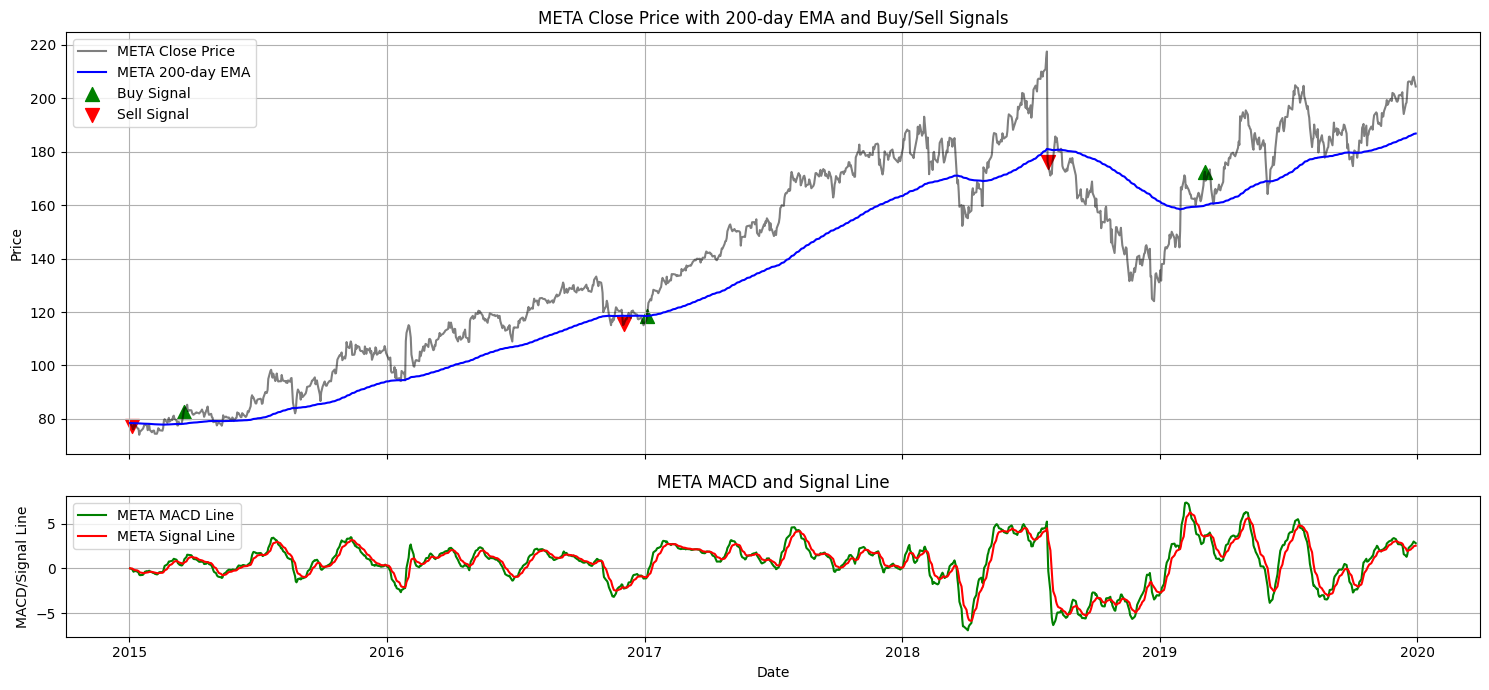

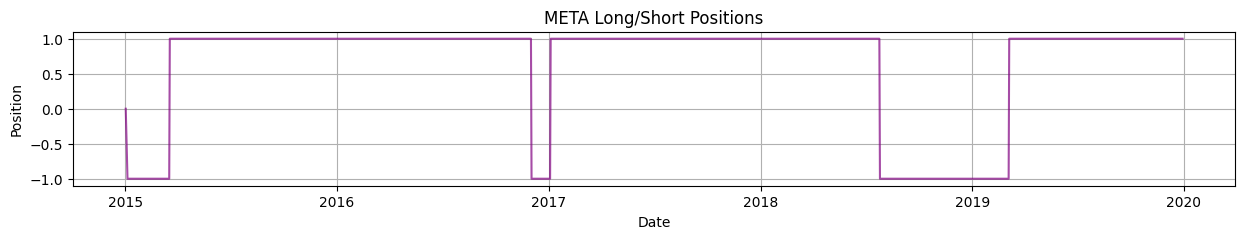

In [72]:
# Visualize and plot for META 

visualize_signals(stock_tables['META'], 'META')
plot_long_short_pos(stock_tables['META'], 'META')

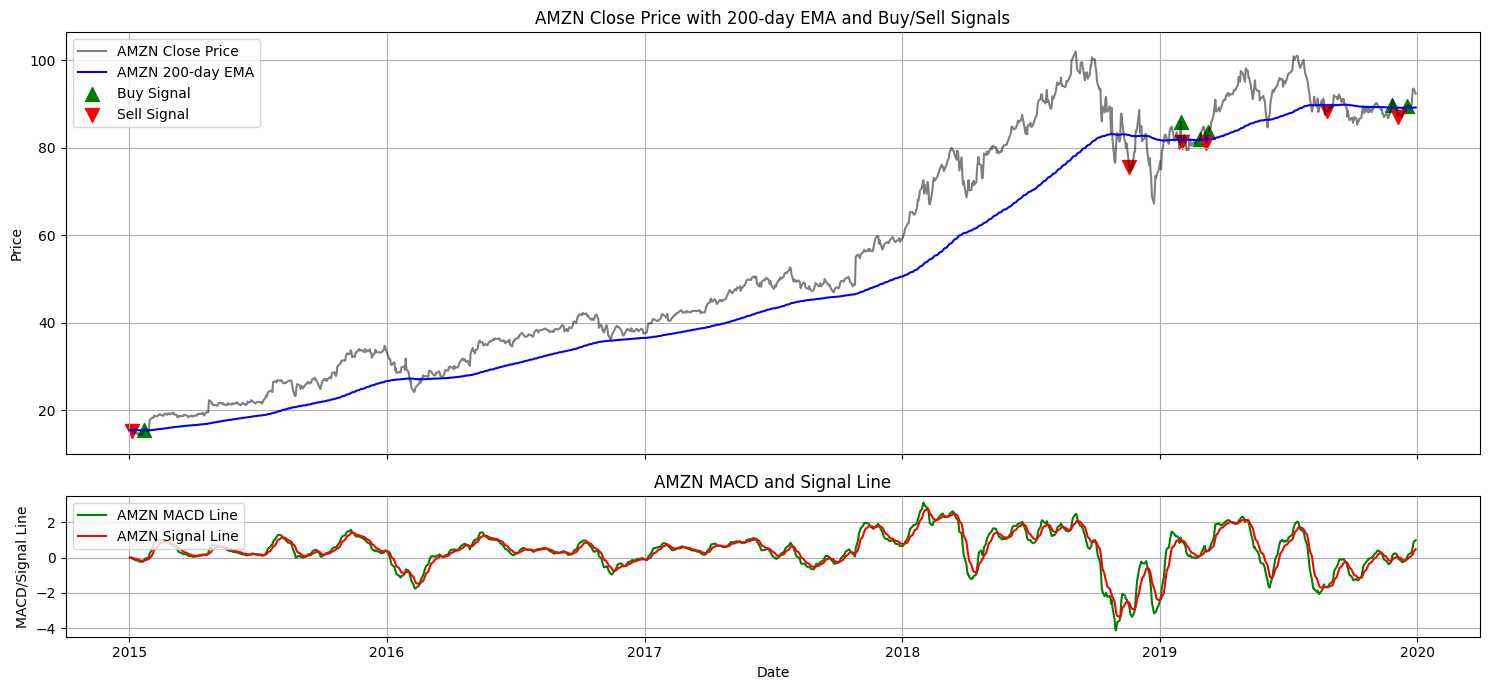

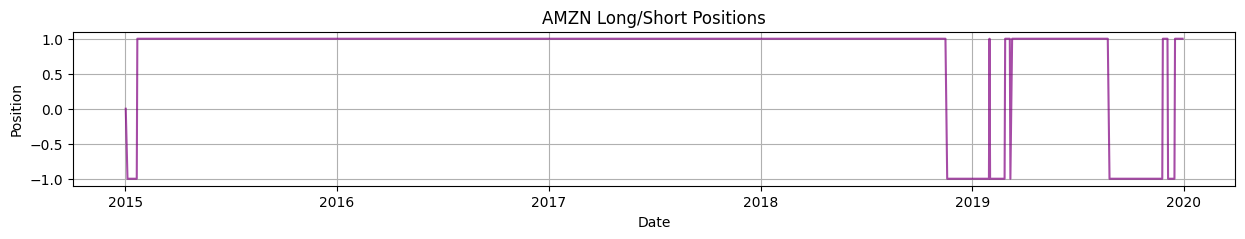

In [73]:
# Visualize and plot for AMZN

visualize_signals(stock_tables['AMZN'], 'AMZN')
plot_long_short_pos(stock_tables['AMZN'], 'AMZN')

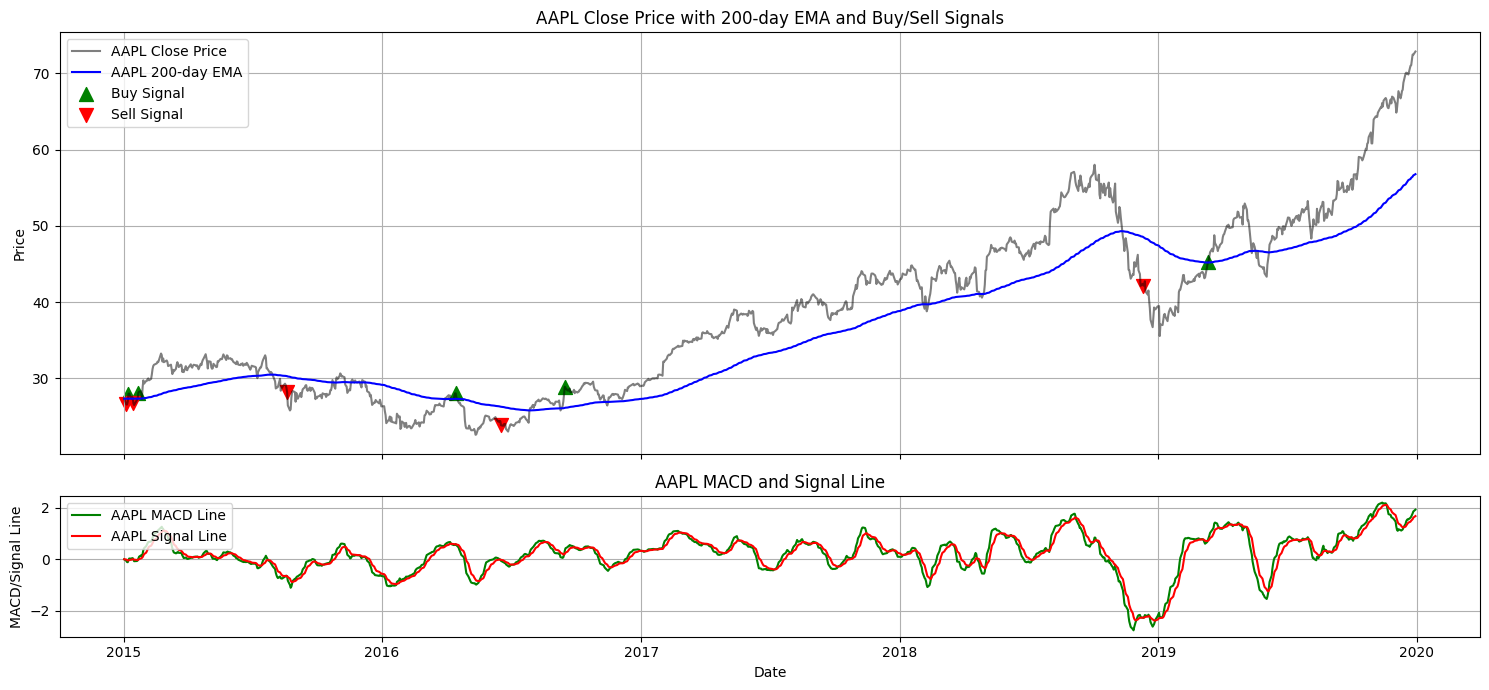

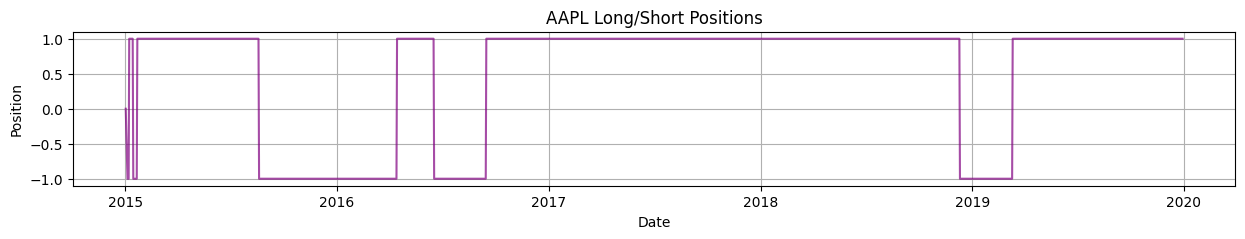

In [74]:
# Visualize and plot for AAPL

visualize_signals(stock_tables['AAPL'], 'AAPL')
plot_long_short_pos(stock_tables['AAPL'], 'AAPL')

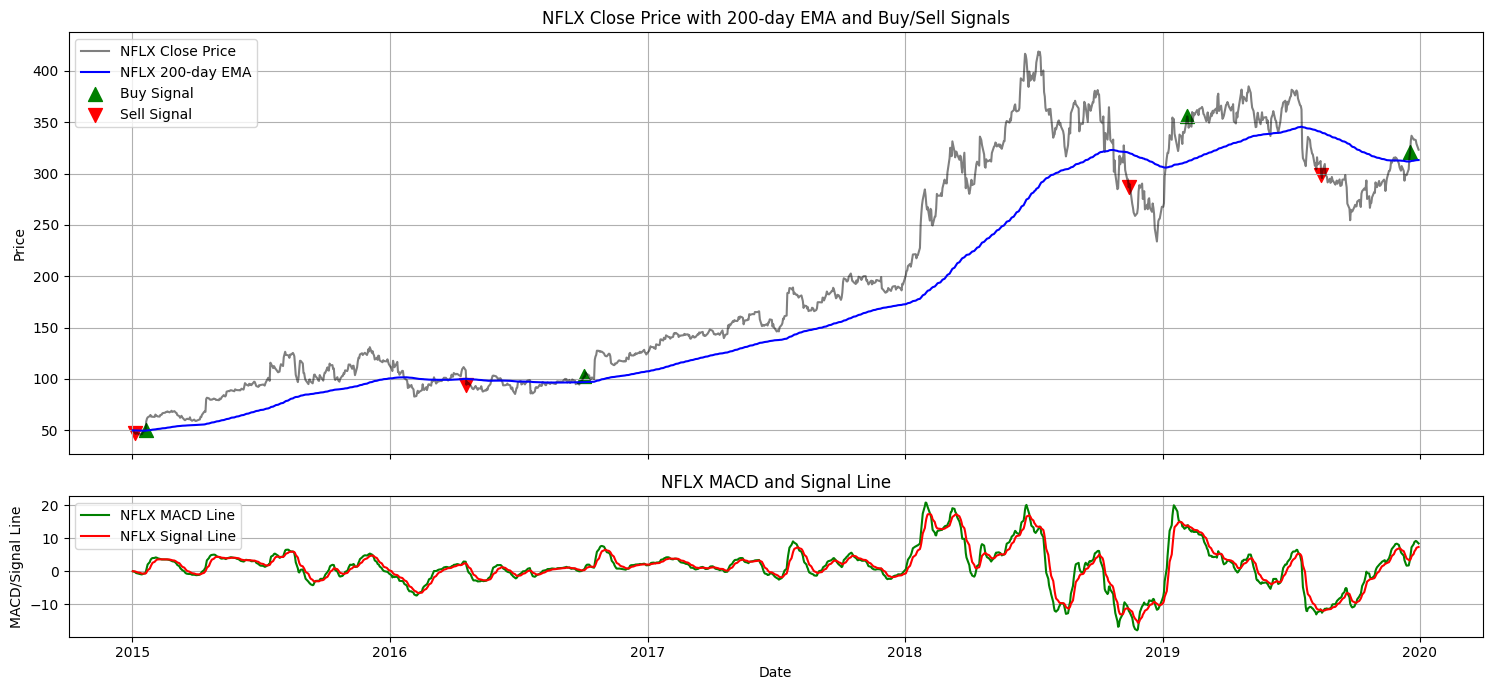

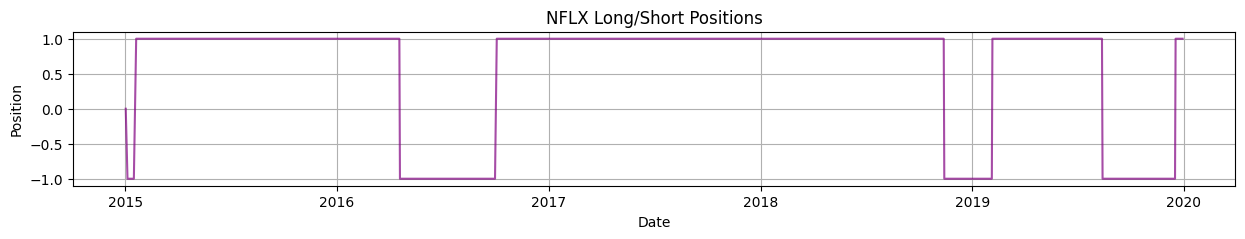

In [75]:
# Visualize and plot for NFLX

visualize_signals(stock_tables['NFLX'], 'NFLX')
plot_long_short_pos(stock_tables['NFLX'], 'NFLX')

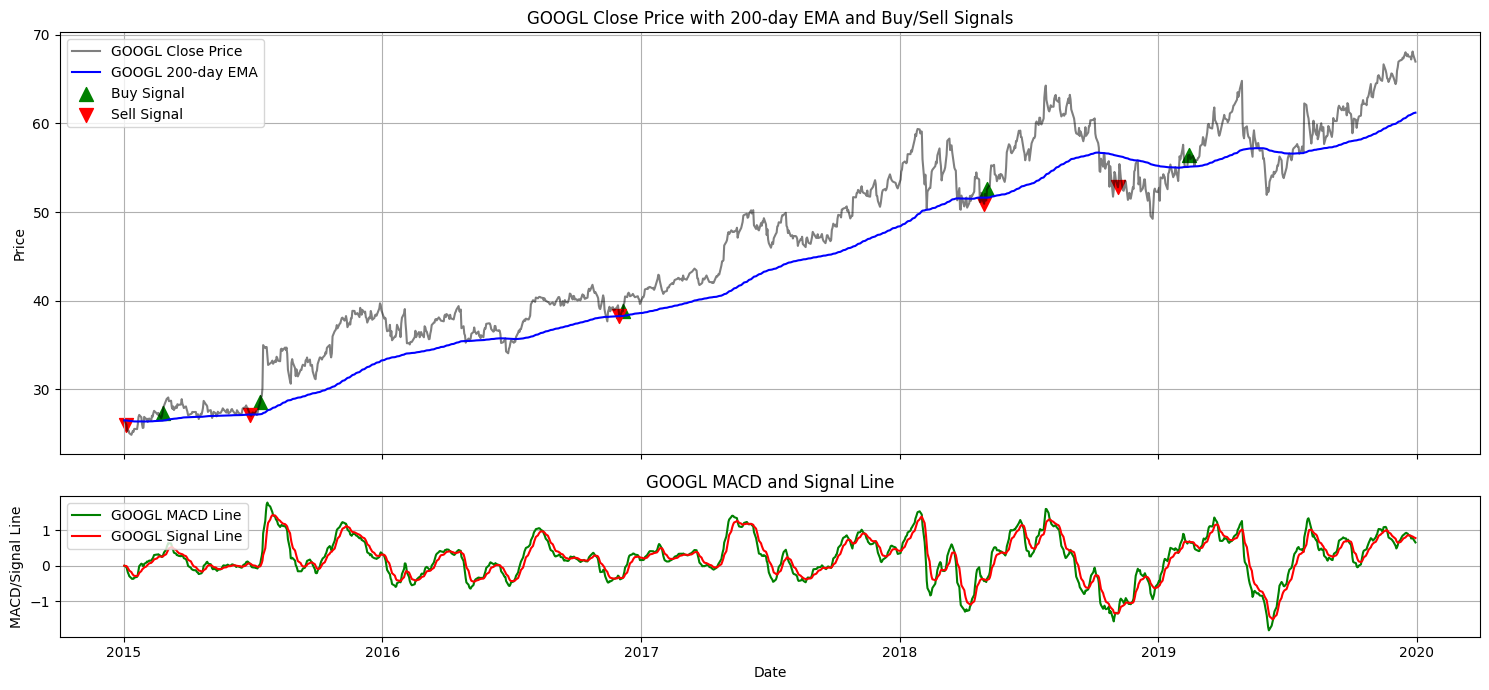

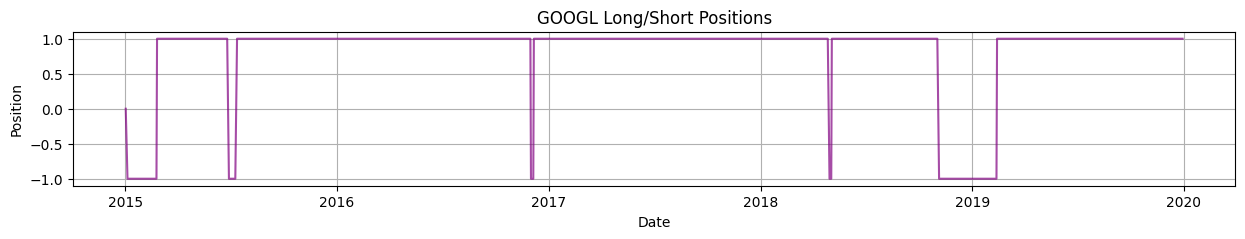

In [76]:
# Visualize and plot for GOOGL

visualize_signals(stock_tables['GOOGL'], 'GOOGL')
plot_long_short_pos(stock_tables['GOOGL'], 'GOOGL')

In [78]:
# ### Calculate individual stock, strategy, and benchmark (equal-weighted MAANG) log returns

def calculate_log_returns(stocks, stock_tables):
    """Calculate log stock, strategy, and benchmark returns for each stock and combined benchmark."""
    
    # Initialize arrays for benchmark and equal-weighted strategy returns
    benchmark_regular_returns = np.zeros(len(stock_tables[stocks[0]])) 
    equal_weighted_regular_returns = np.zeros(len(stock_tables[stocks[0]]))
    
    # Loop through each stock and calculate the log returns
    for stock in stocks:
        stock_data = stock_tables[stock]  # Get the DataFrame for the current stock

        # Calculate log stock returns
        stock_regular_returns = stock_data[f'{stock}_Close'].pct_change()
        stock_data[f'{stock}_Log_Returns'] = np.log(1 + stock_regular_returns)
        
        # Calculate log strategy returns
        strategy_regular_returns = stock_regular_returns * stock_data[f'{stock}_Position'].shift(1)
        stock_data[f'{stock}_Strategy_Log_Returns'] = np.log(1 + strategy_regular_returns)

        # Add stock returns to benchmark and equal-weighted strategy
        benchmark_regular_returns += stock_regular_returns / len(stocks)
        equal_weighted_regular_returns += strategy_regular_returns / len(stocks)

    # Add the benchmark log returns and equal-weighted strategy log returns to each stock's DataFrame
    for stock in stocks:
        stock_data = stock_tables[stock]
        stock_data['Benchmark_Log_Returns'] = np.log(1 + benchmark_regular_returns)
        stock_data['Equal_Weighted_Strategy_Log_Returns'] = np.log(1 + equal_weighted_regular_returns)

    return stock_tables

# Call the function to calculate log returns for each stock
stock_tables = calculate_log_returns(stocks, stock_tables)

# Output the head of each stock's DataFrame
for stock, df in stock_tables.items():
    print(f"Head of {stock} DataFrame:")
    display(df.head())  # Display the first few rows of each stock's data


Head of META DataFrame:


,META_Close,META_EMA_200,META_MACD,META_Signal_Line,META_Position,META_Log_Returns,META_Strategy_Log_Returns,Benchmark_Log_Returns,Equal_Weighted_Strategy_Log_Returns
2015-01-02,78.449997,78.449997,0.000000,0.000000,0,NaN,NaN,NaN,NaN
2015-01-05,77.190002,78.437460,-0.100512,-0.020102,-1,-0.016191,0.000000,-0.027310,0.000000
2015-01-06,76.150002,78.414699,-0.261079,-0.068298,-1,-0.013565,0.013383,-0.015725,0.015482
2015-01-07,76.150002,78.392165,-0.383904,-0.131419,-1,0.000000,0.000000,0.005360,-0.005389
2015-01-08,78.180000,78.390054,-0.313822,-0.167900,-1,0.026309,-0.027020,0.019330,-0.019711


Head of AMZN DataFrame:


,AMZN_Close,AMZN_EMA_200,AMZN_MACD,AMZN_Signal_Line,AMZN_Position,AMZN_Log_Returns,AMZN_Strategy_Log_Returns,Benchmark_Log_Returns,Equal_Weighted_Strategy_Log_Returns
2015-01-02,15.4260,15.426000,0.000000,0.000000,0,NaN,NaN,NaN,NaN
2015-01-05,15.1095,15.422850,-0.025248,-0.005050,-1,-0.020731,0.000000,-0.027310,0.000000
2015-01-06,14.7645,15.416300,-0.072263,-0.018492,-1,-0.023098,0.022577,-0.015725,0.015482
2015-01-07,14.9210,15.411371,-0.095790,-0.033952,-1,0.010544,-0.010656,0.005360,-0.005389
2015-01-08,15.0230,15.407507,-0.104994,-0.048160,-1,0.006813,-0.006859,0.019330,-0.019711


Head of AAPL DataFrame:


,AAPL_Close,AAPL_EMA_200,AAPL_MACD,AAPL_Signal_Line,AAPL_Position,AAPL_Log_Returns,AAPL_Strategy_Log_Returns,Benchmark_Log_Returns,Equal_Weighted_Strategy_Log_Returns
2015-01-02,27.332500,27.332500,0.000000,0.000000,0,NaN,NaN,NaN,NaN
2015-01-05,26.562500,27.324839,-0.061425,-0.012285,-1,-0.028576,0.000000,-0.027310,0.000000
2015-01-06,26.565001,27.317278,-0.108650,-0.031558,-1,0.000094,-0.000094,-0.015725,0.015482
2015-01-07,26.937500,27.313499,-0.114696,-0.048186,-1,0.013925,-0.014121,0.005360,-0.005389
2015-01-08,27.972500,27.320057,-0.035562,-0.045661,1,0.037703,-0.039180,0.019330,-0.019711


Head of NFLX DataFrame:


,NFLX_Close,NFLX_EMA_200,NFLX_MACD,NFLX_Signal_Line,NFLX_Position,NFLX_Log_Returns,NFLX_Strategy_Log_Returns,Benchmark_Log_Returns,Equal_Weighted_Strategy_Log_Returns
2015-01-02,49.848572,49.848572,0.000000,0.000000,0,NaN,NaN,NaN,NaN
2015-01-05,47.311428,49.823327,-0.202393,-0.040479,-1,-0.052238,0.000000,-0.027310,0.000000
2015-01-06,46.501431,49.790273,-0.423272,-0.117037,-1,-0.017269,0.016976,-0.015725,0.015482
2015-01-07,46.742859,49.759950,-0.572243,-0.208078,-1,0.005178,-0.005205,0.005360,-0.005389
2015-01-08,47.779999,49.740249,-0.599701,-0.286403,-1,0.021946,-0.022438,0.019330,-0.019711


Head of GOOGL DataFrame:


,GOOGL_Close,GOOGL_EMA_200,GOOGL_MACD,GOOGL_Signal_Line,GOOGL_Position,GOOGL_Log_Returns,GOOGL_Strategy_Log_Returns,Benchmark_Log_Returns,Equal_Weighted_Strategy_Log_Returns
2015-01-02,26.477501,26.477501,0.000000,0.000000,0,NaN,NaN,NaN,NaN
2015-01-05,25.973000,26.472481,-0.040245,-0.008049,-1,-0.019238,0.000000,-0.027310,0.000000
2015-01-06,25.332001,26.461133,-0.122451,-0.030929,-1,-0.024989,0.024380,-0.015725,0.015482
2015-01-07,25.257500,26.449156,-0.191406,-0.063025,-1,-0.002945,0.002937,0.005360,-0.005389
2015-01-08,25.345501,26.438175,-0.236228,-0.097665,-1,0.003478,-0.003490,0.019330,-0.019711


In [79]:
### Compute the stock and strategy gross performance/returns for all 5 individual stocks and equal-weighted strategy

def calculate_gross_regular_returns(stock_or_strategy, bt_data, is_equal_weighted=False):
    """Calculate gross regular returns for individual stock strategies and equal-weighted strategy and benchmark."""
    
    if is_equal_weighted:
        # Calculate for equal-weighted strategy
        cumulative_strategy_log_return = bt_data['Equal_Weighted_Strategy_Log_Returns'].sum()
        strategy_label = "Equal-Weighted Strategy"
        
    else:
        # Calculate for individual stock
        cumulative_strategy_log_return = bt_data[f'{stock_or_strategy}_Strategy_Log_Returns'].sum()
        cumulative_stock_log_return = bt_data[f'{stock_or_strategy}_Log_Returns'].sum()
        gross_stock_return = np.exp(cumulative_stock_log_return) - 1
        print(f'{stock_or_strategy} Gross Stock Performance: {gross_stock_return:.4f}')
        strategy_label = f'{stock_or_strategy} Strategy'
    
    # Calculate cumulative benchmark log returns
    cumulative_benchmark_log_return = bt_data['Benchmark_Log_Returns'].sum()
    
    # Convert cumulative log returns to gross regular returns
    gross_strategy_return = np.exp(cumulative_strategy_log_return) - 1
    gross_benchmark_return = np.exp(cumulative_benchmark_log_return) - 1
    
    # Print the gross performance of the strategy and benchmark
    print(f'{strategy_label} Performance: {gross_strategy_return:.4f}')
    print(f'Gross Benchmark Performance: {gross_benchmark_return:.4f}\n')

    # Performance comparison for equal-weighted strategy and benchmark
    if is_equal_weighted:
        if gross_strategy_return > gross_benchmark_return:
            print(f'The {strategy_label} outperformed the benchmark by {gross_strategy_return - gross_benchmark_return:.4f}')
        else:
            print(f'The benchmark outperformed the {strategy_label} by {gross_benchmark_return - gross_strategy_return:.4f}')

In [80]:
# Calculate and print performance for META
print("Gross performance/returns for META:\n")
calculate_gross_regular_returns('META', stock_tables['META'])

Gross performance/returns for META:
META Gross Stock Performance: 1.6056
META Strategy Performance: 1.0741
Gross Benchmark Performance: 3.0619



In [82]:
# Calculate and print performance for AMZN
print("Gross performance/returns for AMZN:\n")
calculate_gross_regular_returns('AMZN', stock_tables['AMZN'])

Gross performance/returns for AMZN:

AMZN Gross Stock Performance: 4.9863
AMZN Strategy Performance: 2.5715
Gross Benchmark Performance: 3.0619



In [83]:
# Calculate and print performance for AAPL
print("Gross performance/returns for AAPL:\n")
calculate_gross_regular_returns('AAPL', stock_tables['AAPL'])

Gross performance/returns for AAPL:

AAPL Gross Stock Performance: 1.6664
AAPL Strategy Performance: 0.1993
Gross Benchmark Performance: 3.0619



In [84]:
# Calculate and print performance for NFLX
print("Gross performance/returns for NFLX:\n")
calculate_gross_regular_returns('NFLX', stock_tables['NFLX'])

Gross performance/returns for NFLX:

NFLX Gross Stock Performance: 5.4858
NFLX Strategy Performance: 1.4969
Gross Benchmark Performance: 3.0619



In [85]:
# Calculate and print performance for GOOGL
print("Gross performance/returns for GOOGL:\n")
calculate_gross_regular_returns('GOOGL', stock_tables['GOOGL'])

Gross performance/returns for GOOGL:

GOOGL Gross Stock Performance: 1.5299
GOOGL Strategy Performance: 0.5965
Gross Benchmark Performance: 3.0619



In [86]:
# Calculate performance for the equal-weighted strategy and print the result
print("Gross performance/returns of the equal-weighted strategy and benchmark:\n")
calculate_gross_regular_returns('Equal_Weighted_Strategy', stock_tables[stocks[0]], is_equal_weighted=True)

Gross performance/returns of the equal-weighted strategy and benchmark:

Equal-Weighted Strategy Performance: 1.3248
Gross Benchmark Performance: 3.0619

The benchmark outperformed the Equal-Weighted Strategy by 1.7371


In [88]:
### Visualise the daily stock returns, stock log returns and strategy log returns for all 5 individual stocks

def plot_histogram_of_returns(bt_data, stock):
    """Visualize the histogram of daily log returns."""
    stock_returns = bt_data[f'{stock}_Log_Returns']
    
    # Create a histogram of the stock's daily log returns
    plt.figure(figsize=(10, 4))
    plt.hist(stock_returns.dropna(), bins=40, color='blue', alpha=0.7)  # Drop NA to avoid empty values in the histogram
    plt.title(f'Histogram of {stock} Daily Log Returns')
    plt.xlabel('Log Returns')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def plot_cumulative_returns(bt_data, log_return_column, stock=None, benchmark_column='Benchmark_Log_Returns', title='Cumulative Returns', label=None):
    """Plot cumulative returns for individual stocks or equal-weighted strategy."""
    
    # Calculate regular returns from log returns for the strategy
    strategy_regular_returns = np.exp(bt_data[log_return_column]) - 1
    cumulative_strategy_returns = (strategy_regular_returns + 1).cumprod() - 1

    # Calculate the cumulative benchmark returns from log returns
    benchmark_regular_returns = np.exp(bt_data[benchmark_column]) - 1
    cumulative_benchmark_returns = (benchmark_regular_returns + 1).cumprod() - 1

    # Plot the cumulative returns
    plt.figure(figsize=(10, 5))

    # If plotting for an individual stock, also plot the stock's cumulative returns
    if stock:
        stock_regular_returns = np.exp(bt_data[f'{stock}_Log_Returns']) - 1
        cumulative_stock_returns = (stock_regular_returns + 1).cumprod() - 1
        plt.plot(bt_data.index, cumulative_stock_returns, label=f'{stock} Cumulative Stock Returns', color='blue', alpha=0.7)

    plt.plot(bt_data.index, cumulative_strategy_returns, label=f'{label} Cumulative Strategy Returns', color='green', alpha=0.7)
    plt.plot(bt_data.index, cumulative_benchmark_returns, label='Benchmark Cumulative Returns', color='red', alpha=0.7)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid()
    plt.show()

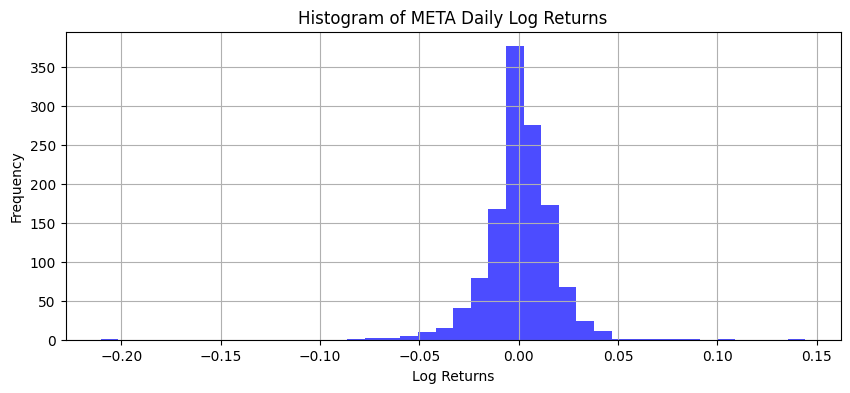

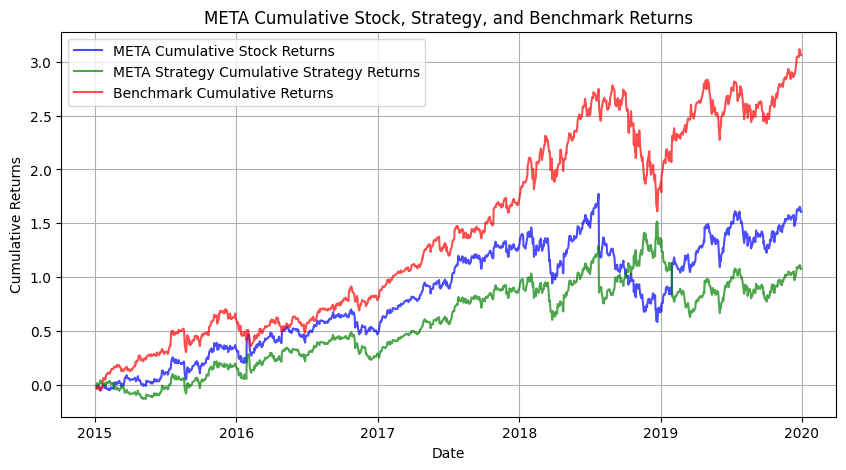

In [89]:
# Plot histogram and cumulative returns for META
plot_histogram_of_returns(stock_tables['META'], 'META')
plot_cumulative_returns(stock_tables['META'], 
                        log_return_column='META_Strategy_Log_Returns', 
                        stock='META', 
                        title='META Cumulative Stock, Strategy, and Benchmark Returns', 
                        label='META Strategy')

**for META returns:**

The histogram of META's daily log returns shows that the majority of returns are clustered around zero, with a slight skew towards negative returns. This suggests that META had more losses than wins. 

In the cumulative returns graph, the strategy returns (green) underperformed compared to both the stock returns (blue) and the benchmark returns (red). The strategy failed to capture significant growth, staying below the stock's natural returns and falling well short of the benchmark's performance. This indicates that the strategy was not able to generate as much profit as simply holding the stock or following the benchmark.

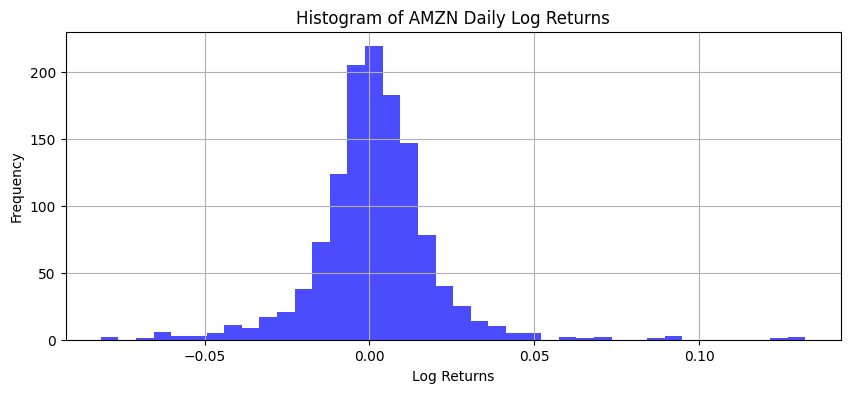

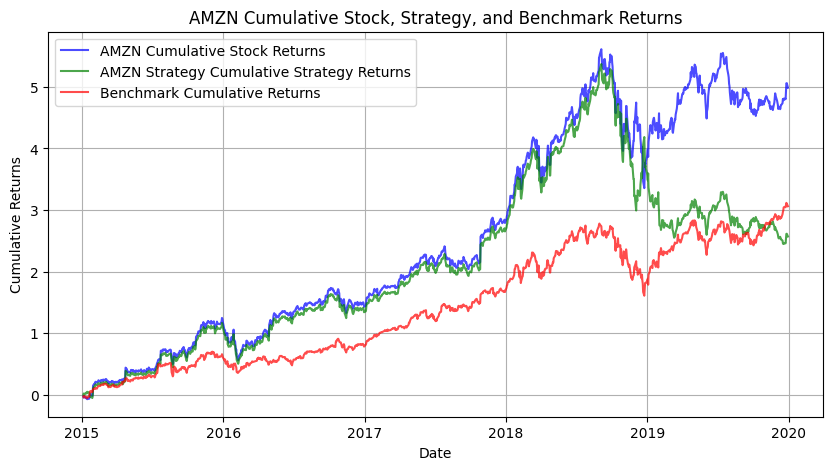

In [90]:
# Plot histogram and cumulative returns for AMZN
plot_histogram_of_returns(stock_tables['AMZN'], 'AMZN')
plot_cumulative_returns(stock_tables['AMZN'], 
                        log_return_column='AMZN_Strategy_Log_Returns', 
                        stock='AMZN', 
                        title='AMZN Cumulative Stock, Strategy, and Benchmark Returns', 
                        label='AMZN Strategy')

**for AMZN returns:**

The histogram of AMZN's daily log returns shows that the majority of returns are clustered around zero, with a slight skew towards positive returns. This suggests that AMZN had more wins but small wins with certain outliers who made large wins.

In the cumulative returns graph, the strategy returns (green) outperformed the benchmark returns (red), indicating that the strategy was able to achieve better returns than the equal-weighted portfolio of stocks. However, the strategy still underperformed the stock returns (blue), failing to fully capture AMZN’s strong growth during certain periods, especially in 2019. While the strategy performed better than the benchmark, it lagged behind simply holding AMZN stock.

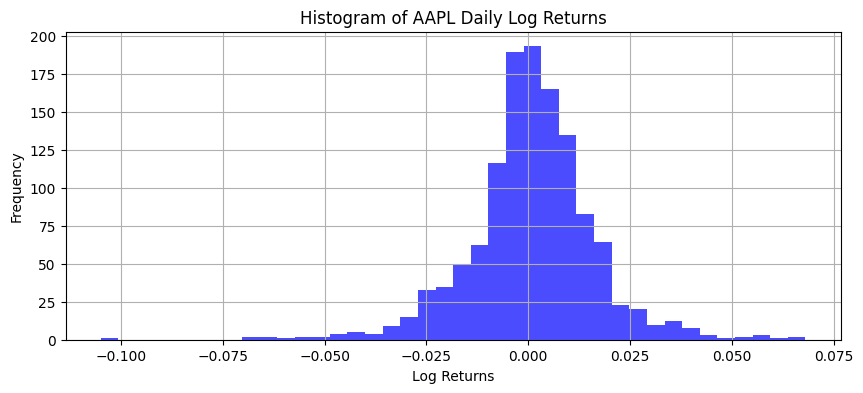

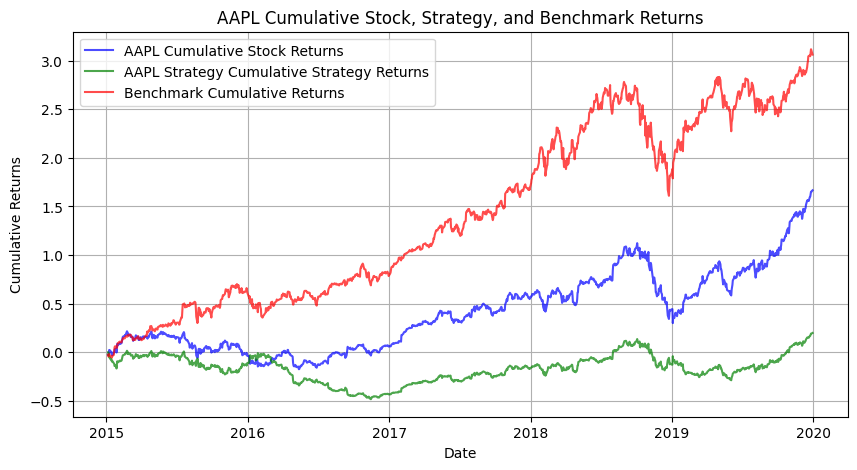

In [91]:
# Plot histogram and cumulative returns for AAPL
plot_histogram_of_returns(stock_tables['AAPL'], 'AAPL')
plot_cumulative_returns(stock_tables['AAPL'], 
                        log_return_column='AAPL_Strategy_Log_Returns', 
                        stock='AAPL', 
                        title='AAPL Cumulative Stock, Strategy, and Benchmark Returns', 
                        label='AAPL Strategy')

**for AAPL returns:**

The histogram of AAPL's daily log returns shows that the majority of returns are clustered around zero, with a slight skew towards positive returns. This suggests that AAPL had more wins although they seem to have been small wins.

In the cumulative returns graph, the strategy returns (green) underperformed both the stock returns (blue) and the benchmark returns (red). The strategy failed to capture significant growth, remaining flat while AAPL's stock saw substantial gains, particularly from 2017 onwards. This indicates that the strategy was not effective in capitalizing on AAPL's growth momentum and lagged far behind both the stock's natural performance and the benchmark throughout the period.

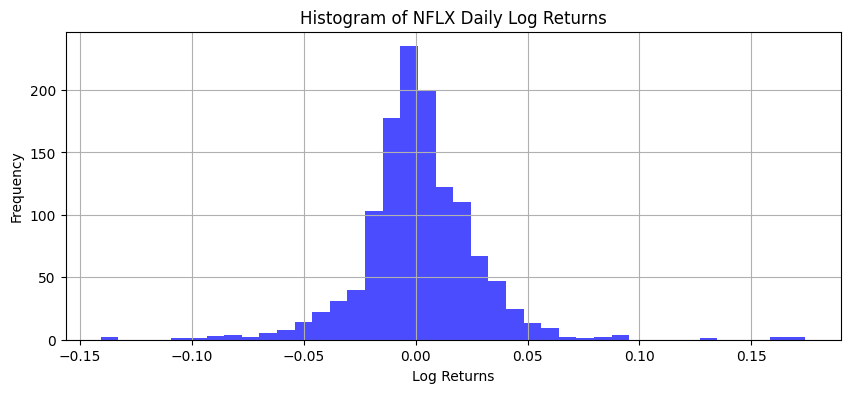

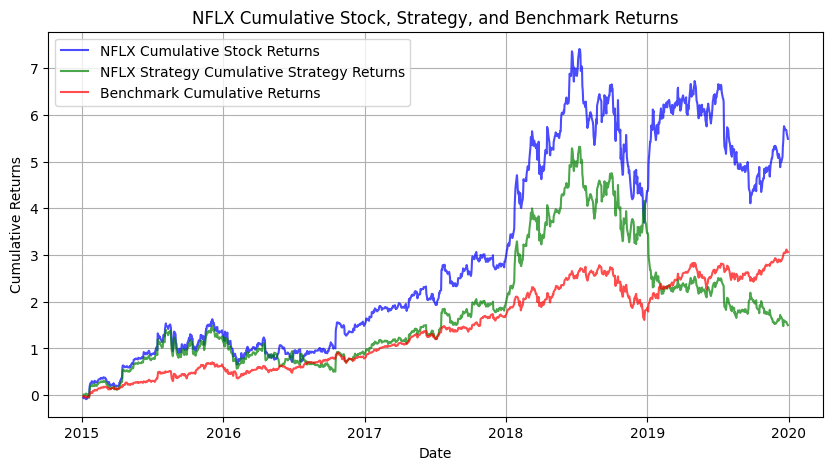

In [92]:
# Plot histogram and cumulative returns for NFLX
plot_histogram_of_returns(stock_tables['NFLX'], 'NFLX')
plot_cumulative_returns(stock_tables['NFLX'], 
                        log_return_column='NFLX_Strategy_Log_Returns', 
                        stock='NFLX', 
                        title='NFLX Cumulative Stock, Strategy, and Benchmark Returns', 
                        label='NFLX Strategy')

**for NFLX returns:**

The histogram of NFLX's daily log returns shows that the majority of returns are clustered around zero, with a slight skew towards negative returns. This suggests that NFLX had more losses but small losses.

In the cumulative returns graph, the strategy returns (green) outperformed the benchmark returns (red) for most of the period. However, starting around 2019, the strategy started to underperform relative to the benchmark. Despite this late decline, the strategy still captured some gains compared to the benchmark over the majority of the period. However, the strategy underperformed the stock returns (blue) significantly, missing out on the substantial growth that NFLX stock experienced, particularly between 2016 and mid-2018.

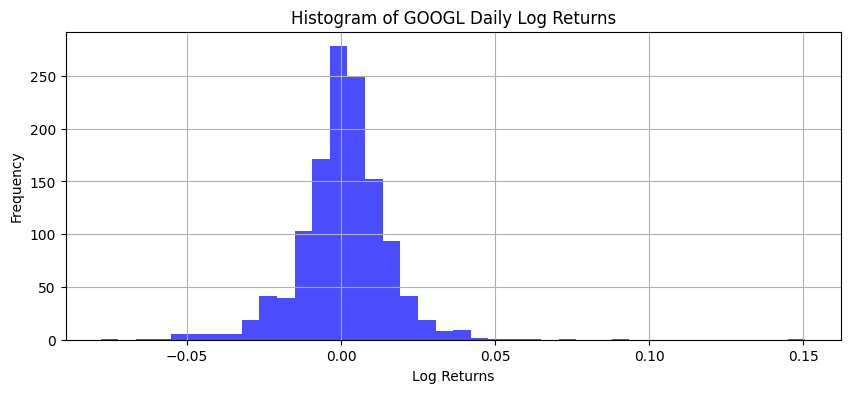

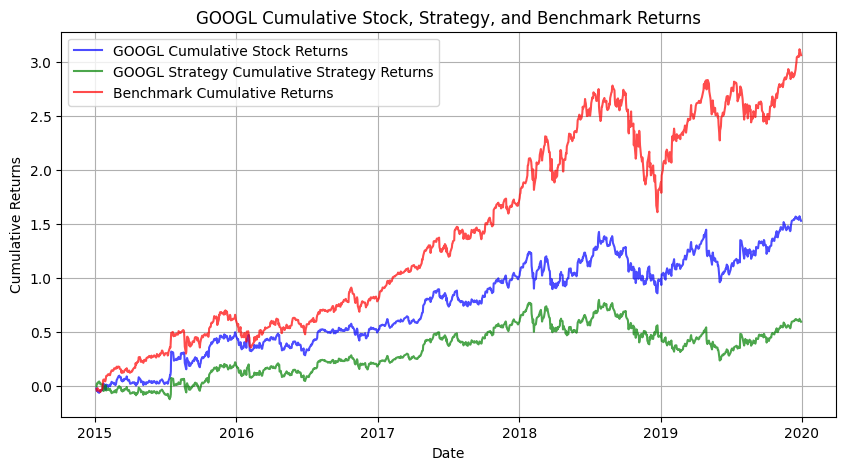

In [93]:
# Plot histogram and cumulative returns for GOOGL
plot_histogram_of_returns(stock_tables['GOOGL'], 'GOOGL')
plot_cumulative_returns(stock_tables['GOOGL'], 
                        log_return_column='GOOGL_Strategy_Log_Returns', 
                        stock='GOOGL', 
                        title='GOOGL Cumulative Stock, Strategy, and Benchmark Returns', 
                        label='GOOGL Strategy')

**for GOOGL returns:**

The histogram of GOOGL's daily log returns shows that the majority of returns are clustered around zero, with a somewhat equal distribution between negative and postive returns. This suggests that GOOGL had an approximately equal number of losses and wins although the losses seem to have been larger losses compared to the win which seem to be smaller wins.

In the cumulative returns graph, the strategy returns (green) underperformed both the stock returns (blue) and the benchmark returns (red) over the entire period. The strategy failed to capture the significant growth seen in GOOGL's stock, which saw steady upward movement throughout 2016 to 2019. The strategy’s cumulative returns remained relatively flat, showing that it was not able to effectively capitalize on GOOGL’s overall performance and significantly lagged behind both the stock and benchmark returns.

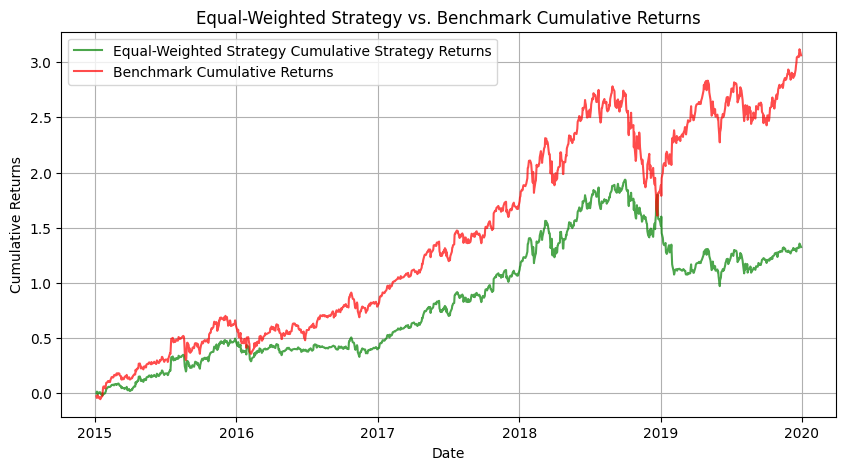

In [94]:
# Similarly, plot the cumulative returns of equal-weighted strategy consisting of our 5 individual stock strategies
plot_cumulative_returns(stock_tables[stocks[0]], 
                        log_return_column='Equal_Weighted_Strategy_Log_Returns', 
                        title='Equal-Weighted Strategy vs. Benchmark Cumulative Returns', 
                        label='Equal-Weighted Strategy')

The equal-weighted strategy (green) significantly underperformed compared to the benchmark returns (red) throughout the entire period. While the strategy did capture some gains, its performance remained relatively flat, especially in 2016, where the benchmark experienced substantial growth. This underperformance indicates that the strategy failed to take full advantage of market opportunities, falling well short of the benchmark's returns.

In [95]:
### Compute annualised returns, risk, and performance metrics for individual stock strategies and equal-weighted strategy

def calculate_performance_metrics(bt_data, log_return_columns, strategy_name="", risk_free_rate=0.0):
    """Calculate the annualized returns, risks, Sharpe ratio, Sortino ratio, Treynor ratio, tracking error, and information ratio."""

    # 1. Annualized Expected Returns for the given strategy and benchmark
    daily_log_returns = bt_data[log_return_columns].mean()
    annual_log_returns = daily_log_returns * 252

    # Convert to annualized regular returns
    annual_regular_returns = np.exp(annual_log_returns) - 1

    # 2. Annualized Risk (Standard Deviation) for the given strategy and benchmark
    daily_log_std = bt_data[log_return_columns].std()
    annual_log_std = daily_log_std * np.sqrt(252)

    # Convert to annualized standard deviation
    daily_regular_std = (np.exp(bt_data[log_return_columns]) - 1).std()
    annual_regular_std = daily_regular_std * np.sqrt(252)

    # 3. Sharpe Ratio for the given strategy and benchmark
    sharpe_ratio = annual_regular_returns / annual_regular_std

    # 4. Beta for the strategy against the benchmark
    covariance = bt_data[log_return_columns].cov().iloc[0, 1]
    variance_market = bt_data[log_return_columns[1]].var()
    beta_value = covariance / variance_market

    # 5. Alpha for the strategy against the benchmark
    market_return_annualized = bt_data[log_return_columns[1]].mean() * 252
    strategy_return_annualized = bt_data[log_return_columns[0]].mean() * 252
    alpha_value = strategy_return_annualized - (beta_value * market_return_annualized)

    # 6. Sortino Ratio
    excess_return = bt_data[log_return_columns[0]] - risk_free_rate / 252
    negative_return = bt_data[log_return_columns[0]][bt_data[log_return_columns[0]] < 0]
    downside_deviation = np.std(negative_return) * np.sqrt(252)
    sortino_ratio = (excess_return.mean() * 252) / downside_deviation

    # 7. Treynor Ratio (using calculated beta)
    treynor_ratio = (excess_return.mean() * 252) / beta_value

    # 8. Tracking Error
    active_return = bt_data[log_return_columns[0]] - bt_data[log_return_columns[1]]
    tracking_error = np.std(active_return) * np.sqrt(252)

    # 9. Information Ratio
    information_ratio = (active_return.mean() * 252) / tracking_error

    # Display the results for each strategy
    strategy_label = f"{strategy_name} " if strategy_name else ""
    print(f"\nPerformance Summary for {strategy_label}vs. Benchmark:\n")
    
    print("Annualized Regular Returns:")
    print(f"{strategy_label}Strategy: {annual_regular_returns[log_return_columns[0]]:.4f}")
    print(f"Benchmark: {annual_regular_returns[log_return_columns[1]]:.4f}\n")
    
    print("Annualized Risk (Standard Deviation):")
    print(f"{strategy_label}Strategy: {annual_regular_std[log_return_columns[0]]:.4f}")
    print(f"Benchmark: {annual_regular_std[log_return_columns[1]]:.4f}\n")
    
    print("Sharpe Ratio:")
    print(f"{strategy_label}Strategy: {sharpe_ratio[log_return_columns[0]]:.4f}")
    print(f"Benchmark: {sharpe_ratio[log_return_columns[1]]:.4f}\n")

    print("Beta:")
    print(f"{strategy_label}Beta: {beta_value:.4f}\n")
    
    print("Alpha:")
    print(f"{strategy_label}Alpha: {alpha_value:.4f}\n")
    
    print("Sortino Ratio:")
    print(f"{strategy_label}Sortino: {sortino_ratio:.4f}\n")
    
    print("Treynor Ratio:")
    print(f"{strategy_label}Treynor: {treynor_ratio:.4f}\n")
    
    print("Tracking Error:")
    print(f"{strategy_label}Tracking Error: {tracking_error:.4f}\n")
    
    print("Information Ratio:")
    print(f"{strategy_label}Information Ratio: {information_ratio:.4f}\n")

In [96]:
# Example usage for META
calculate_performance_metrics(stock_tables['META'], 
                              [f'META_Strategy_Log_Returns', 'Benchmark_Log_Returns'], 
                              strategy_name='META Strategy')


Performance Summary for META Strategy vs. Benchmark:

Annualized Regular Returns:
META Strategy Strategy: 0.1576
Benchmark: 0.3247

Annualized Risk (Standard Deviation):
META Strategy Strategy: 0.2823
Benchmark: 0.2282

Sharpe Ratio:
META Strategy Strategy: 0.5583
Benchmark: 1.4228

Beta:
META Strategy Beta: 0.4549

Alpha:
META Strategy Alpha: 0.0185

Sortino Ratio:
META Strategy Sortino: 0.6080

Treynor Ratio:
META Strategy Treynor: 0.3218

Tracking Error:
META Strategy Tracking Error: 0.2929

Information Ratio:
META Strategy Information Ratio: -0.4605



In [97]:
# Example usage for AMZN
calculate_performance_metrics(stock_tables['AMZN'], 
                              [f'AMZN_Strategy_Log_Returns', 'Benchmark_Log_Returns'], 
                              strategy_name='AMZN Strategy')


Performance Summary for AMZN Strategy vs. Benchmark:

Annualized Regular Returns:
AMZN Strategy Strategy: 0.2910
Benchmark: 0.3247

Annualized Risk (Standard Deviation):
AMZN Strategy Strategy: 0.2930
Benchmark: 0.2282

Sharpe Ratio:
AMZN Strategy Strategy: 0.9932
Benchmark: 1.4228

Beta:
AMZN Strategy Beta: 0.6671

Alpha:
AMZN Strategy Alpha: 0.0678

Sortino Ratio:
AMZN Strategy Sortino: 1.2055

Treynor Ratio:
AMZN Strategy Treynor: 0.3829

Tracking Error:
AMZN Strategy Tracking Error: 0.2592

Information Ratio:
AMZN Strategy Information Ratio: -0.0996



In [98]:
# Example usage for AAPL
calculate_performance_metrics(stock_tables['AAPL'], 
                              [f'AAPL_Strategy_Log_Returns', 'Benchmark_Log_Returns'], 
                              strategy_name='AAPL Strategy')


Performance Summary for AAPL Strategy vs. Benchmark:

Annualized Regular Returns:
AAPL Strategy Strategy: 0.0371
Benchmark: 0.3247

Annualized Risk (Standard Deviation):
AAPL Strategy Strategy: 0.2488
Benchmark: 0.2282

Sharpe Ratio:
AAPL Strategy Strategy: 0.1493
Benchmark: 1.4228

Beta:
AAPL Strategy Beta: 0.1939

Alpha:
AAPL Strategy Alpha: -0.0181

Sortino Ratio:
AAPL Strategy Sortino: 0.1940

Treynor Ratio:
AAPL Strategy Treynor: 0.1881

Tracking Error:
AAPL Strategy Tracking Error: 0.3064

Information Ratio:
AAPL Strategy Information Ratio: -0.7988



In [99]:
# Example usage for NFLX
calculate_performance_metrics(stock_tables['NFLX'], 
                              [f'NFLX_Strategy_Log_Returns', 'Benchmark_Log_Returns'], 
                              strategy_name='NFLX Strategy')


Performance Summary for NFLX Strategy vs. Benchmark:

Annualized Regular Returns:
NFLX Strategy Strategy: 0.2015
Benchmark: 0.3247

Annualized Risk (Standard Deviation):
NFLX Strategy Strategy: 0.4170
Benchmark: 0.2282

Sharpe Ratio:
NFLX Strategy Strategy: 0.4833
Benchmark: 1.4228

Beta:
NFLX Strategy Beta: 0.8078

Alpha:
NFLX Strategy Alpha: -0.0436

Sortino Ratio:
NFLX Strategy Sortino: 0.6610

Treynor Ratio:
NFLX Strategy Treynor: 0.2273

Tracking Error:
NFLX Strategy Tracking Error: 0.3714

Information Ratio:
NFLX Strategy Information Ratio: -0.2629



In [100]:
# Example usage for GOOGL
calculate_performance_metrics(stock_tables['GOOGL'], 
                              [f'GOOGL_Strategy_Log_Returns', 'Benchmark_Log_Returns'], 
                              strategy_name='GOOGL Strategy')


Performance Summary for GOOGL Strategy vs. Benchmark:

Annualized Regular Returns:
GOOGL Strategy Strategy: 0.0984
Benchmark: 0.3247

Annualized Risk (Standard Deviation):
GOOGL Strategy Strategy: 0.2380
Benchmark: 0.2282

Sharpe Ratio:
GOOGL Strategy Strategy: 0.4135
Benchmark: 1.4228

Beta:
GOOGL Strategy Beta: 0.5427

Alpha:
GOOGL Strategy Alpha: -0.0588

Sortino Ratio:
GOOGL Strategy Sortino: 0.5344

Treynor Ratio:
GOOGL Strategy Treynor: 0.1729

Tracking Error:
GOOGL Strategy Tracking Error: 0.2271

Information Ratio:
GOOGL Strategy Information Ratio: -0.8251



In [101]:
# Example usage for the equal-weighted strategy
calculate_performance_metrics(stock_tables[stocks[0]],  # You can use any stock's DataFrame (e.g., META)
                              ['Equal_Weighted_Strategy_Log_Returns', 'Benchmark_Log_Returns'], 
                              strategy_name="Equal-Weighted Strategy")



Performance Summary for Equal-Weighted Strategy vs. Benchmark:

Annualized Regular Returns:
Equal-Weighted Strategy Strategy: 0.1844
Benchmark: 0.3247

Annualized Risk (Standard Deviation):
Equal-Weighted Strategy Strategy: 0.1965
Benchmark: 0.2282

Sharpe Ratio:
Equal-Weighted Strategy Strategy: 0.9384
Benchmark: 1.4228

Beta:
Equal-Weighted Strategy Beta: 0.5342

Alpha:
Equal-Weighted Strategy Alpha: 0.0190

Sortino Ratio:
Equal-Weighted Strategy Sortino: 1.0784

Treynor Ratio:
Equal-Weighted Strategy Treynor: 0.3169

Tracking Error:
Equal-Weighted Strategy Tracking Error: 0.1876

Information Ratio:
Equal-Weighted Strategy Information Ratio: -0.5969



In [102]:
### Plot cumulative maximum graph, calculate max drawdown, and max drawdown period

def calculate_and_plot_drawdown(bt_data, log_return_column, stock=None, strategy_name=""):
    """Calculate and plot the drawdown, max drawdown, and the period over which the max drawdown occurs."""
    
    # Calculate gross cumulative returns
    gross_cum_returns = np.exp(bt_data[log_return_column].cumsum())
    bt_data[f'{strategy_name}_Gross_Cum_Returns'] = gross_cum_returns
    
    # Calculate the cumulative maximum
    cum_max = gross_cum_returns.cummax()
    bt_data[f'{strategy_name}_Cum_Max'] = cum_max
    
    # Calculate the drawdown (cumulative max - gross cumulative returns)
    drawdown = cum_max - gross_cum_returns
    bt_data[f'{strategy_name}_Drawdown'] = drawdown
    
    # Plot cumulative returns and cumulative max
    plt.figure(figsize=(15, 5))
    bt_data[[f'{strategy_name}_Gross_Cum_Returns', f'{strategy_name}_Cum_Max']].dropna().plot(ax=plt.gca())
    plt.title(f'{strategy_name} Gross Cumulative Returns and Drawdown')
    plt.ylabel('Cumulative Returns')
    plt.grid(True)
    plt.show()

    # Calculate the maximum drawdown
    max_drawdown = drawdown.max()

    # Find the period over which the maximum drawdown occurred
    zero_drawdown_periods = bt_data[bt_data[f'{strategy_name}_Drawdown'] == 0].index
    
    if len(zero_drawdown_periods) > 1:
        # Calculate the difference between consecutive periods of zero drawdown
        delta_values = zero_drawdown_periods[1:] - zero_drawdown_periods[:-1]
        max_drawdown_duration = delta_values.max()
    else:
        # No drawdown periods
        max_drawdown_duration = None
    
    print(f'Max Drawdown for {strategy_name}: {max_drawdown:.4f}')
    if max_drawdown_duration:
        print(f'Max Drawdown Period for {strategy_name}: {max_drawdown_duration}')
    else:
        print(f'No significant drawdown periods for {strategy_name}.')

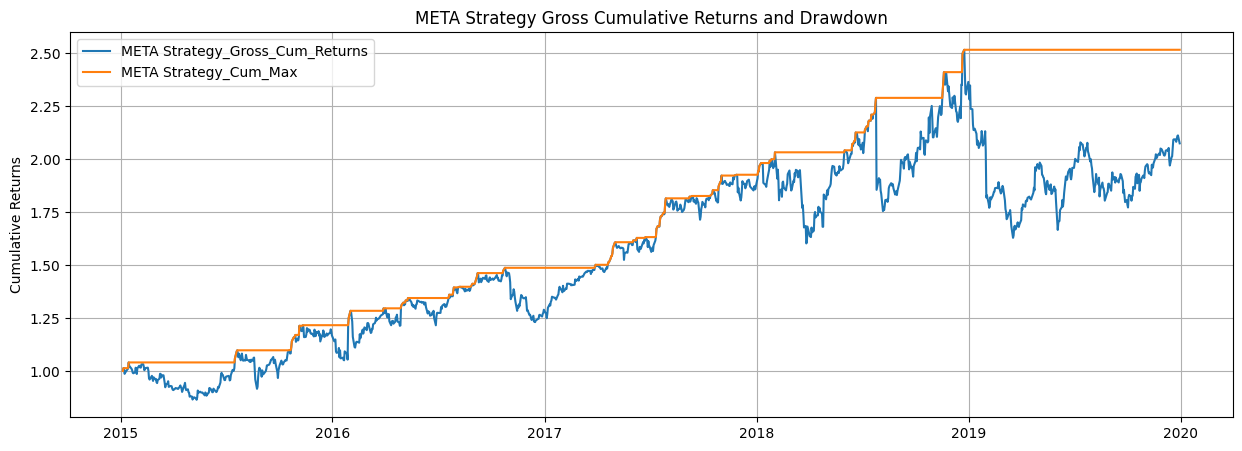

Max Drawdown for META Strategy: 0.8874
Max Drawdown Period for META Strategy: 183 days 00:00:00


In [103]:
# Calculate and plot drawdown for META Strategy
calculate_and_plot_drawdown(stock_tables['META'], 
                            log_return_column='META_Strategy_Log_Returns', 
                            stock='META', 
                            strategy_name='META Strategy')

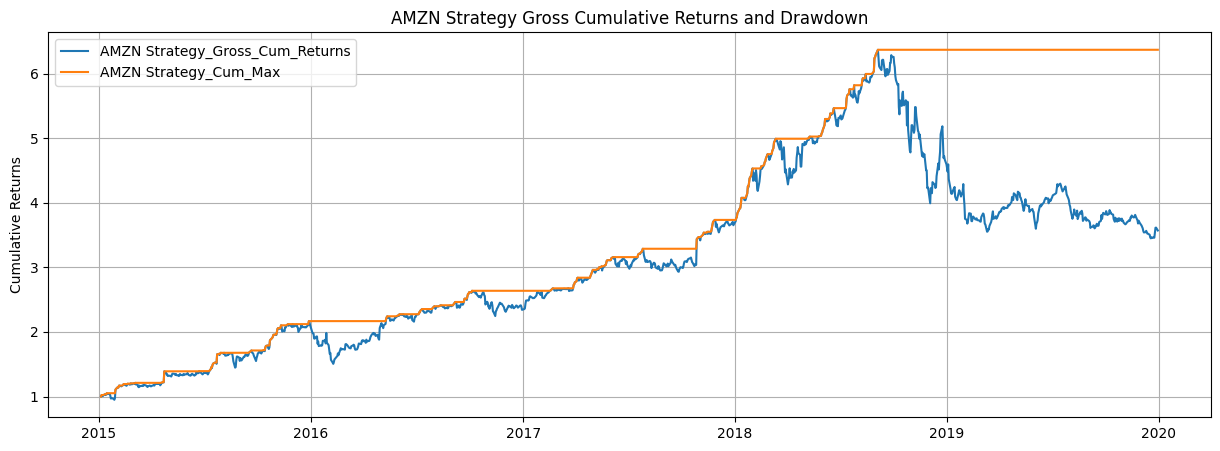

Max Drawdown for AMZN Strategy: 2.9205
Max Drawdown Period for AMZN Strategy: 135 days 00:00:00


In [104]:
# Calculate and plot drawdown for AMZN Strategy
calculate_and_plot_drawdown(stock_tables['AMZN'], 
                            log_return_column='AMZN_Strategy_Log_Returns', 
                            stock='AMZN', 
                            strategy_name='AMZN Strategy')

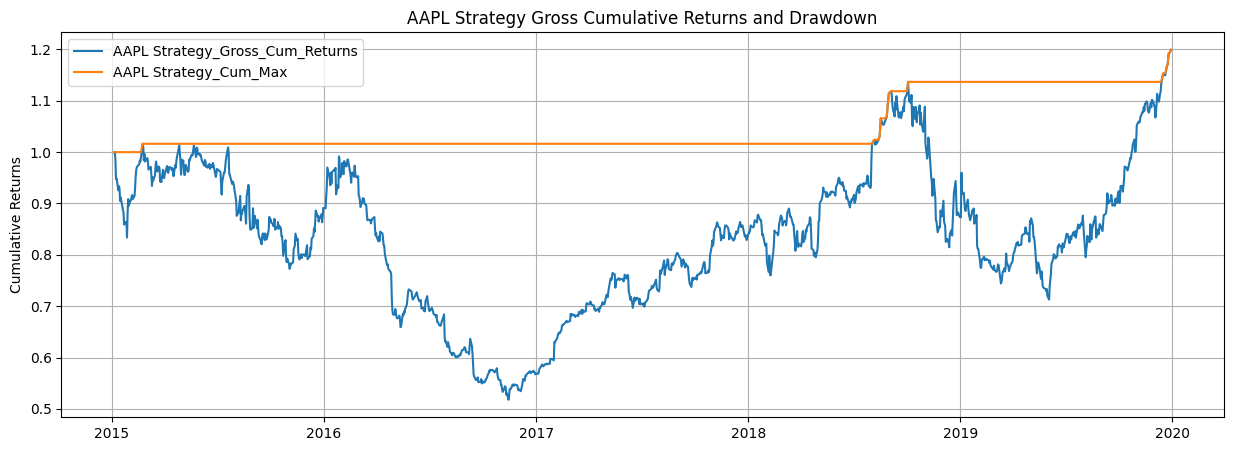

Max Drawdown for AAPL Strategy: 0.4984
Max Drawdown Period for AAPL Strategy: 1257 days 00:00:00


In [105]:
# Calculate and plot drawdown for AAPL Strategy
calculate_and_plot_drawdown(stock_tables['AAPL'], 
                            log_return_column='AAPL_Strategy_Log_Returns', 
                            stock='AAPL', 
                            strategy_name='AAPL Strategy')

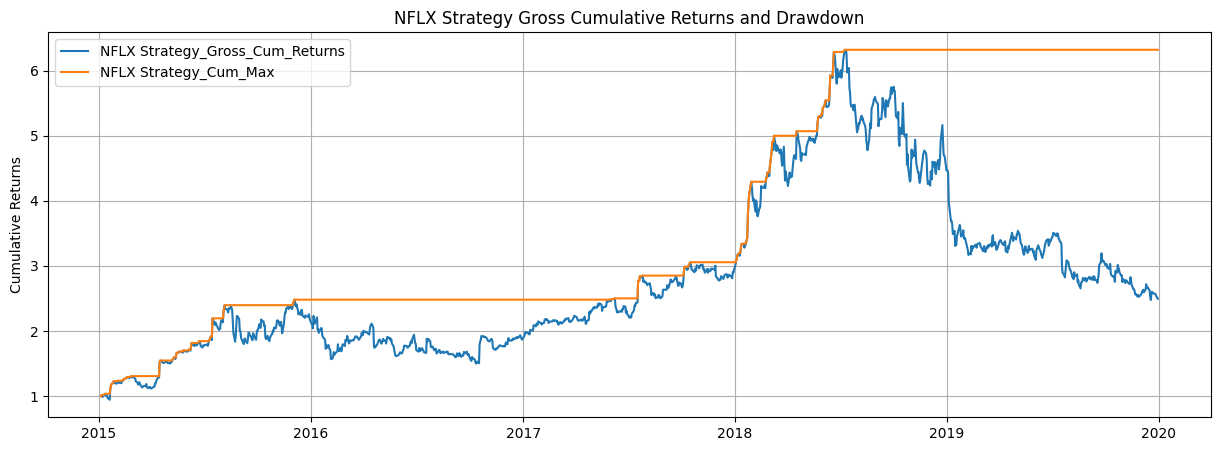

Max Drawdown for NFLX Strategy: 3.8406
Max Drawdown Period for NFLX Strategy: 546 days 00:00:00


In [106]:
# Calculate and plot drawdown for NFLX Strategy
calculate_and_plot_drawdown(stock_tables['NFLX'], 
                            log_return_column='NFLX_Strategy_Log_Returns', 
                            stock='NFLX', 
                            strategy_name='NFLX Strategy')

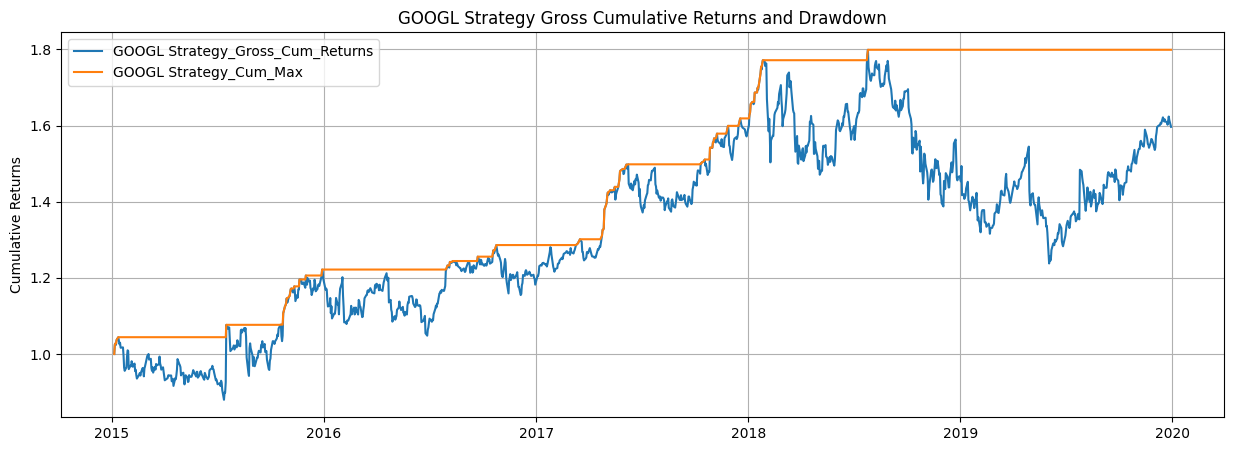

Max Drawdown for GOOGL Strategy: 0.5611
Max Drawdown Period for GOOGL Strategy: 216 days 00:00:00


In [107]:
# Calculate and plot drawdown for GOOGL Strategy
calculate_and_plot_drawdown(stock_tables['GOOGL'], 
                            log_return_column='GOOGL_Strategy_Log_Returns', 
                            stock='GOOGL', 
                            strategy_name='GOOGL Strategy')

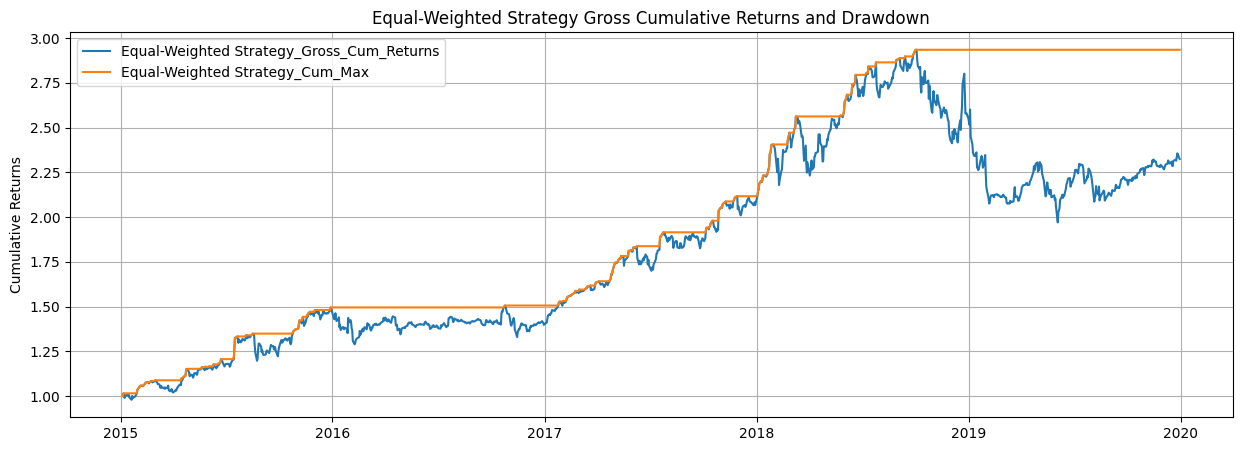

Max Drawdown for Equal-Weighted Strategy: 0.9643
Max Drawdown Period for Equal-Weighted Strategy: 300 days 00:00:00


In [108]:
# Calculate and plot drawdown for the equal-weighted strategy
calculate_and_plot_drawdown(stock_tables[stocks[0]],  
                            log_return_column='Equal_Weighted_Strategy_Log_Returns', 
                            strategy_name="Equal-Weighted Strategy")
